# ORIENTATION IN MEDICAL IMAGING
    
![Coordinate Systems][Coordinate Systems]

## World Coordinate System:
Coordinate system in which the patient is positionned in the PET, CT or MR

## Anatomical Coordinate System:
- *Axial plane* is parallel to the groud and separates the head (Superior) from the feet (Inferior). It corresponds with the $z$ axis in the world coordinate system.
- *Coronal plane* is perpendicular to the ground and separates the front (Anterior) from the back (Posterior). It corresponds with the $y$ axis world coordinate system.
- *Sagittal plane* separates the left from the right. It corresponds with the $x$ axis world coordinate system.

Most common definitions are:
- **LPS** (Left, Posterior, Superior): used in DICOM format and by (Simple)ITK
$$    
LPS = \begin{Bmatrix}
        \text{from right towards left} \\
        \text{from anterior towards posterior} \\
        \text{from inferior towards superior}
      \end{Bmatrix}
$$

- **RAS** (Right, Anterior, Superior) or Neurological convention: used by NIfTI format and by NiBabel and SPM
$$    
RAS = \begin{Bmatrix}
        \text{from left towards right} \\
        \text{from posterior towards anterior} \\
        \text{from inferior towards superior}
      \end{Bmatrix}
$$    

- **LAS** (Left, Anterior, Superoir) or Radiological convetion: used by ANALYZE format
$$    
LAS = \begin{Bmatrix}
        \text{from right towards left} \\
        \text{from posterior towards anterior} \\
        \text{from inferior towards superior}
      \end{Bmatrix}
$$       

## Image Coordinate System
The image coordinate system describes how an image was acquired with respect to the anatomy. Medical scanners create regular, rectangular arrays of points and cells which start at the upper left corner.
The *i* axis increases to the right, the *j* axis to the bottom and the *k* axis backwards.

The file standard assumes that the voxel coordinates refer to the center of each voxel, rather than at any of its corners.

In addition to the intensity value of each voxel $(i,j,k)$ the origin and spacing of the anatomical coordinates are stored too.

The *origin of coordinates* represents the position of the first voxel (0,0,0) in the anatomical coordinate system, e.g. (100mm, 50mm, -25mm)

The *spacing* specifies the distance between voxels along each axis, e.g. (1.5mm, 0.5mm, 0.5mm)

## Image Transformation
The transformation from an image space vector to an anatomical space vector is an affine transformation, consists of a linear transformation followed by a translation.

### Quarternions:
The orientation of the $(x,y,z)$ axes relative to the $(i,j,k)$ axes in the image space is specified using a unit quaternion $[a,b,c,d]$, where $a*a+b*b+c*c+d*d=1$. The $(b,c,d)$ values are all that is needed, since it is required that $a = \sqrt{1.0-(b*b+c*c+d*d)}$ be non negative. The $(b,c,d)$ values are stored in the $(quatern_b,quatern_c,quatern_d)$ fields.

### The Purpose of the qform and sform in NIfTI files

The `qform` and `sform` stored in a NIfTI file header are intended to fulfil the following functions:
- specify the handedness of the coordinate system (important for getting left and right correct)
- specify the original scanner coordinates (`qform` only)
- specify standard space coordinates (`sform` only)
- specify a relationship with another image's coordinates (`sform` only) 

The `qform` and `sform` should never specify coordinates with different handedness (i.e. have determinants of different signs). Otherwise it is not possible to tell left from right.

According to NIfTI-1 Standard [1], the `qform` code should be set to either *unknown (0)* or *scanner_anat (1)*. While, The `sform` code should be set to either *unknown (0)*, *aligned_anat (2)*, *tailarach (3)* or *mni_152 (4)*.


### Orientation information

| Name         | Code | Description |
|--------------|:----:|-------------|
| unknown      | 0    | Arbitrary coordinates. |
| scanner_anat | 1    | Scanner-based anatomical coordinates. |
| aligned_anat | 2    | Coordinates aligned to another file, or to the “truth” (with an arbitrary coordinate center). |
| talairach    | 3    | Coordinates aligned to the Talairach space. |
| mni_152      | 4    | Coordinates aligned to the mni space. |

#### Method 1 (The "old" way)

| Form       | Code     |
|------------|----------|
| qform_code | 0        |
| sform_code | Not used |

The coordinate mapping from $(i,j,k)$ to $(x,y,z)$ is the ANALYZE 7.5 way.
This is a simple scaling relationship:
$$
\left[ \begin{array}{c} x\\ y\\ z \end{array} \right]= \left[ \begin{array}{c} i\\ j\\ k \end{array} \right]\odot \left[ \begin{array}{c} \mathtt{pixdim[1]}\\ \mathtt{pixdim[2]}\\ \mathtt{pixdim[3]}\\ \end{array} \right]
$$

No particular spatial orientation is attached to these $(x,y,z)$ coordinates. This method is not recommended, and is present mainly for compatibility with ANALYZE 7.5 files.

#### Method 2: qform_code > 0 (Recommended)

It is intended to be used to indicate the scanner coordinates, in a way that resembles the coordinates specified in the DICOM header. It can also be used to represent the alignment of an image to a previous session of the same subject (such as for coregistration).

$$ 
\mathbf{R} = \left[ \begin{array}{ccc} a^2+b^2-c^2-d^2 & 2(bc-ad) & 2(bd+ac) \\ 2(bc+ad) & a^2+c^2-b^2-d^2 & 2(cd-ab) \\ 2(bd-ac) & 2(cd+ab) & a^2+d^2-b^2-c^2 \end{array} \right]
$$
$$
\left[ \begin{array}{c} x\\ y\\ z \end{array} \right]=\mathbf{R} \left[ \begin{array}{c} i\\ j\\ q\cdot k\\ \end{array} \right]\odot \left[ \begin{array}{c} \mathtt{pixdim[1]}\\ \mathtt{pixdim[2]}\\ \mathtt{pixdim[3]}\\ \end{array} \right]+ \left[ \begin{array}{c} \mathtt{qoffset\_x}\\ \mathtt{qoffset\_y}\\ \mathtt{qoffset\_z}\\ \end{array} \right]
$$

#### Method 3: sform_code > 0

The $(x,y,z)$ coordinates are given by a general affine transformation of the $(i,j,k)$ indexes:

$$
\left[ \begin{array}{c} x\\ y\\ z\\ 1 \end{array} \right]=\left[ \begin{array}{cccc} \mathtt{srow\_x[0]} & \mathtt{srow\_x[1]} & \mathtt{srow\_x[2]} & \mathtt{srow\_x[3]}\\ \mathtt{srow\_y[0]} & \mathtt{srow\_y[1]} & \mathtt{srow\_y[2]} & \mathtt{srow\_y[3]}\\ \mathtt{srow\_z[0]} & \mathtt{srow\_z[1]} & \mathtt{srow\_z[2]} & \mathtt{srow\_z[3]} \\ 0 & 0 & 0 & 1\end{array} \right]\cdot\left[ \begin{array}{c} i\\ j\\ k\\ 1 \end{array} \right]
$$

#### Why 3 Methods?
   
Method 1 is provided only for backwards compatibility.  The intention is that Method 2 (qform_code > 0) represents the nominal voxel locations    as reported by the scanner, or as rotated to some fiducial orientation and location.  Method 3, if present (sform_code > 0), is to be used to give the location of the voxels in some standard space. The `sform_code` indicates which standard space is present. Both methods 2 and 3 can be    present, and be useful in different contexts (method 2 for displaying the data on its original grid; method 3 for displaying it on a standard grid).

In this scheme, a dataset would originally be set up so that the Method 2 coordinates represent what the scanner reported. Later, a registration to some standard space can be computed and inserted in the header.


# Main Software packages

## Row- and column-major order

Please, be aware that different programming languages or libraries store the data in different order. This might be of importance, for example, when reading raw data (e.g. Volumes-of_interest created in ACCURATE) or when multiple libreries are used (SimpleITK and NiBabel)


| Programming languages and libraries | Row-major | Column-major |
|-------------------------------------|:---------:|:------------:|
| Python: SimpleITK                   |     x     |              |
| Python: Numpy                       |     x     |              |
| C/C++                               |     x     |              |
| Matlab                              |           |       x      |
| ACCURATE                            |           |              |

Transposition of the data solved the differences.

## ITK & SimpleITK
ITK and SimpleITK use the LPS convention. After reading a file, the data matrix is stored as $(z,y,x)$. However, when writing a NIfTI file they convert the data matrix to RAS.

## NiBabel

NiBabel uses the RAS convention. After reading a file, the data matrix is stored as $(x,y,z)$.

## LPS (DICOM) to RAS (NIfTI)
DICOM's coordinate system is 180 degrees rotated about the z-axis from the neuroscience/NIFTI coordinate system. 
To transform between DICOM and NIFTI, you just have to negate the x- and y-coordinates.
  



(Simple)ITK converts the data matrix to RAS when writing the NIfTI
    
Further details in:
- https://brainder.org/2012/09/23/the-nifti-file-format/
- https://www.slicer.org/wiki/Coordinate_systems

[//]: # (Links & Images)
[Coordinate Systems]: images/Coordinate_systems.png
[1]: https://nifti.nimh.nih.gov/


# Python: NiBabel

For this example we will use a NIfTI file and the NiBabel library

In [2]:
!cls
# Libraries
import os
import copy
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Input data
cwd = os.getcwd()
os.chdir(cwd)

## Neurological Convention RAS (RL)

'Raw data matrix:'

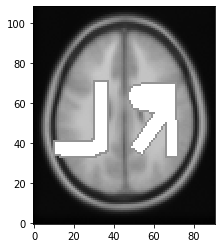

qform_code: 0
qform matrix: 
 [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]] 

sform_code: 4
sform matrix: 
 [[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]] 



In [3]:
filename = os.path.join(cwd,'data','nifti1','avg152T1_RL_nifti.nii.gz') # Neurological Convention RAS
# Load file with NiBabel
img      = nib.load(filename)

# Load the data matrix
#img_data = img.get_data()  # uint8
img_data = img.get_fdata() # float32

# Display data matrix
display('Raw data matrix:')
plt.imshow(img_data[:,:,50].T, cmap="gray", origin="lower")  # Data needs to be transposed for visualization
plt.show()

# Orientation information
print('qform_code:', img.header['qform_code']) # 0: unknown
print('qform matrix: \n', img.get_qform(), '\n')

print('sform_code:', img.header['sform_code']) # 4: mni_152
print('sform matrix: \n', img.get_sform(), '\n')

## Radiological Convention LAS (LR)

'Raw data matrix:'

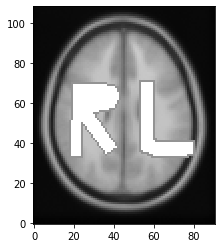

qform_code: 0
qform matrix: 
 [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]] 

sform_code: 4
sform matrix: 
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]] 



In [4]:
filename = os.path.join(cwd,'data','nifti1','avg152T1_LR_nifti.nii.gz') # Radiological Convention LAS
# Load file with NiBabel
img      = nib.load(filename)

# Load the data matrix
#img_data = img.get_data()  # uint8
img_data = img.get_fdata() # float32

# Display data matrix
display('Raw data matrix:')
plt.imshow(img_data[:,:,50].T, cmap="gray", origin="lower")  # Data needs to be transposed for visualization
plt.show()

# Orientation information
print('qform_code:', img.header['qform_code']) # 0: unknown
print('qform matrix: \n', img.get_qform(), '\n')

print('sform_code:', img.header['sform_code']) # 4: mni_152
print('sform matrix: \n', img.get_sform(), '\n')

NiBabel always uses RAS output space


# Conversion of DICOM to NIfTI

In [14]:
''''' Important DICOM tags
For further info:
http://dicom.nema.org/dicom/2013/output/chtml/part04/sect_I.4.html
https://www.dicomlibrary.com/dicom/sop/ 

(0008,0016) SOP Class UID
            1.2.840.10008.5.1.4.1.1.128 - Positron Emission Tomography Image

(0018,5100) HFS or FFS (Empty if Unknown)
            HFS: Head First Supine
            FFS: Feet Fitst Supine
            HFP: Head First Prone
            FFP: Feet First Prone

(0020,0032) x,y,z coordinates of the upper left hand corner (center of the first voxel transmitted) of the image, in mm (Required tag)

(0020,0037) Image Orientation of the patient (Expected 1\0\0\0\1\0)
            Direction cosines of the first row and the first column with respect to the patient

(0028,1052) Intercept

(0028,1053) Slope

(0054,1000) Series Type of the scan

(0054,0414) Patient Gantry Relationship Code Sequence, i.e. orientation of the patient within the gantry.(Empty if Unknown)
            Code Meaning | Retired code | Replacement Code
            Headfirst    | G-5190       | F-10470
            Feetfirst    | G-5191       | F-10480

(0054,1330) An index identifying the position of this image within a PET Series
'''''

!cls
## Libraries
import os
import numpy as np
import nibabel as nib
import pydicom
import tkinter as tk
from tkinter import filedialog

## Input data
# Test data
#input_dicom_dir = os.path.join('data','phantom_EARL1')
#output_dir      = os.path.join('data','output')
# GUI
root = tk.Tk()   # Creates a blank window with close, maximize and minimize buttons.
root.withdraw()  # We don't want a full GUI, so keep the root window from appearing
input_dicom_dir = os.path.abspath(filedialog.askdirectory(title="Please select the input DICOM folder"))

root.deiconify() # Makes the window visible again
output_dir = os.path.abspath(filedialog.askdirectory(title="Please select a folder to save output NIfTI file(s)"))
root.destroy()

study_name      = 'Phantom_EARL1'

## Predefined variables
ideal_Image_Orientation = ['1', '0', '0', '0', '1', '0']

## Functions
def read_dicom_files(input_dicom_dir):
    dicom_files = os.listdir(input_dicom_dir)
    
    try:
        ds_list = [pydicom.dcmread(os.path.join(input_dicom_dir, filename), force = False) \
                   for filename in dicom_files \
                   if filename.endswith(('.IMA','.dcm'))]
    except:
        sys.exit("Not a valid DICOM files were found. Only .IMA and .dcm is implemented.")
        
    return ds_list

def sort_dicom_files(ds_list):    
    sorted_ds_list = ds_list.copy()
    sorted_ds_list.sort(key = lambda x: int(x.ImageIndex))
    
    return sorted_ds_list

def get_img_volume(sorted_ds_list):
    # Get the voxel intensity array of each slice and stack it in the z-direction
    
    # Transpose the array to change the array order from row-major to column-major
    # ToDo : Preallocate variable
    img_volume_data = np.transpose(sorted_ds_list[0].pixel_array)
    
    for ds in sorted_ds_list[1:]:
        img_slice_data = ds.pixel_array
        img_slice_data_transposed = img_slice_data.T
        img_volume_data = np.dstack((img_volume_data, img_slice_data_transposed))
    
    Image_Orientation = sorted_ds_list[0].ImageOrientationPatient   # (0020,0037)
    
    Patient_Position = sorted_ds_list[0].PatientPosition            # (0018,5100)
    
    patient_orientation_code = sorted_ds_list[0].PatientGantryRelationshipCodeSequence._list[0].CodeValue # (0054,0414)
    patient_orientation = sorted_ds_list[0].PatientGantryRelationshipCodeSequence._list[0].CodeMeaning 
    
    
    Image_Position_0 = sorted_ds_list[0].ImagePositionPatient # (0020,0032)
    Image_Position_1 = sorted_ds_list[1].ImagePositionPatient # (0020,0032)
    
    # Check for the Patient Position: HFS or FFS, and reorder the slices in z-direction accordingly
    if str(Image_Orientation) == str(ideal_Image_Orientation):
        
        print("Ideal Image Orientation (0020,0037). Processing...")
        
        if Patient_Position == "HFS" and patient_orientation_code == 'F-10470' and patient_orientation == 'headfirst':
            
            print("Head First Supine (HFS). Processing...")
            
            if int(Image_Position_0[2]) > int(Image_Position_1[2]):
                
                print("PET slice z-coordinate decreases -> Flip in z-coordinates applied")
                
                final_ds_list = sorted_ds_list.copy()                
                final_ds_list.reverse()
                
                img_volume_data_final = np.transpose(final_ds_list[0].pixel_array)
    
                for ds in final_ds_list[1:]:
                    img_slice_data_final = ds.pixel_array
                    img_slice_data_final_transposed = img_slice_data_final.T
                    img_volume_data_final = np.dstack((img_volume_data_final, img_slice_data_final_transposed))
                
            elif int(Image_Position_0[2]) < int(Image_Position_1[2]):
                
                print("PET slice z-coordinate increases. Please, check DICOM information.")
            
        elif Patient_Position == "FFS" and patient_orientation_code == 'F-10480' and patient_orientation == 'feet-first':            
            print("Feet First Supine (FFS). Processing...")
            
            if int(Image_Position_0[2]) < int(Image_Position_1[2]):                
                print("PET slice z-coordinate increases. Processing...")                
                img_volume_data_final = img_volume_data
            
            elif int(Image_Position_0[2]) > int(Image_Position_1[2]):                
                print("PET slice z-coordinate decreases. Please, check DICOM information.") 
                
        else:
            sys.exit("Sorry, this orientation was not implemented yet.")
    
    else:
        sys.exit("Please, check Image Orientation tag (0020,0037) and Patient Gantry Relationship tag (0054,0414)")
        
    return img_volume_data_final

''''' No need to anonymize now the DICOM
def get_header_data(dcm_set, output_filename):    
    anonymize_flag = "Y"
    patient_tags = ['PatientID', 'PatientName', 'PatientBirthDate']
      
    output_txt_filename = output_filename + ".txt"
    
    file = open(os.path.join(output_dir,output_txt_filename), "w") 
    for header_tag in dcm_set[0].iterall():
        if anonymize_flag == "Y":
            if header_tag not in [dcm_set[0].data_element(tag) for tag in patient_tags]:
                file.write(str(header_tag) + '\n')
    file.close() 
'''''

def convert_to_nifti(dcm_set, output_file, frame_number, scan_duration_in_sec):
    
    img_volume_data_final = get_img_volume(dcm_set)
    
    # From LPS in DICOM to RAS in NIfTI
    img_data = np.fliplr(img_volume_data_final)
    img_data_volume = np.flipud(img_data)
    #img_data_volume = np.rot90(img_volume_data_final, 2) # Alternative: 180 rotation instead of two flips
    
    Pixel_Spacing = dcm_set[0].PixelSpacing
    
    Slice_Thickness = dcm_set[0].SliceThickness
    
    voxel_size = np.array([float(Pixel_Spacing[0]), float(Pixel_Spacing[1]), float(Slice_Thickness)])
        
    slope = dcm_set[0].RescaleSlope         # (0028,1053)        
    intercept = dcm_set[0].RescaleIntercept # (0028,1052)
    
    # Change the datatype from int to float and apply slope and intercept to the array
    img_data_volume = img_data_volume.astype(float)
    img_data_volume_final = (img_data_volume * slope) + intercept
               
    # Origin of coordinates: centre of the image
    center = (voxel_size * img_data_volume.shape) / 2
    
    # Affine matrix
    apply_affine       = np.diag([voxel_size[0], voxel_size[1], voxel_size[2], 1])
    apply_affine[:3,3] = np.array([-center[0], -center[1], -center[2]])
    
    nii_out = nib.Nifti1Image(img_data_volume_final, apply_affine)
    
    # Adjust NIfTI header
    nii_out.header['qform_code'] = 1
    nii_out.header['sform_code'] = 2

    #nii_out.set_data_dtype(np.float32)
    #xyz_unit = 'mm'
    #nii_out.header.set_xyzt_units(xyz=xyz_unit)
    #nii_out.header.set_data_offset(352)
    #nii_out.header['extents'] = 16384   # Remove?
    #nii_out.header['regular'] = 'r'     # Remove?
    #nii_out.header['intent_name'] = 0   # Remove?
    #nii_out.header['cal_max'] = np.max(img_data_volume_final)    # Check if present in header if not specified
    #nii_out.header['cal_min'] = np.min(img_data_volume_final)    # Check if present in header if not specified        
    
    # Save the NIfTI file
    nib.save(nii_out, output_file)  
    
    print("DICOM converted to NIfTI: ",output_file)

## Read DICOM
ds_list = read_dicom_files(input_dicom_dir) # Read the DICOM files from the directory     
sorted_ds_list = sort_dicom_files(ds_list)  # Sort the DICOM files based on Image Index (0054,1330)

# Check DICOM modality
if sorted_ds_list[0].Modality == 'PT' and sorted_ds_list[0].SOPClassUID == '1.2.840.10008.5.1.4.1.1.128':    
    print("PET image. Processing...")
    
    # Number of slices per frame
    nr_of_slices = sorted_ds_list[0].NumberOfSlices
    
    frame_number = 1
    
    nr_of_dcm_files = len(sorted_ds_list)
    
    scan_series_type = sorted_ds_list[0].SeriesType[0] # (0054,1000) 
    
    if scan_series_type == 'STATIC' or scan_series_type == 'WHOLE BODY':        
        print("Static scan. Processing...")        
        scan_duration_in_msec = sorted_ds_list[0].ActualFrameDuration        
        scan_duration_in_sec = int(scan_duration_in_msec / 1000)    
        output_file = "s" + str(frame_number) + "_" + str(scan_duration_in_sec) + "s_" + study_name + ".nii"
        output_file = os.path.join(output_dir, output_file)
        convert_to_nifti(sorted_ds_list, output_file, frame_number, scan_duration_in_msec)         
        
    elif scan_series_type == 'DYNAMIC':        
        print("Dynamic scan. Processing...")        
        nr_of_time_frames = sorted_ds_list[0].NumberOfTimeSlices        
        
        # split files in multiple of nr_of_slices. Each frame has "nr_of_slices" slices   
        dcm_set_split_by_frames = [sorted_ds_list[x:x+nr_of_slices] for x in range(0, len(sorted_ds_list), nr_of_slices)]
            
        for dcm_set in dcm_set_split_by_frames:            
            scan_duration_in_msec = dcm_set[0].ActualFrameDuration        
            scan_duration_in_sec = int(scan_duration_in_msec / 1000)                        
            output_file = "s" + str(frame_number) + "_" + str(scan_duration_in_sec) + "s_" + study_name + ".nii"
            output_file = os.path.join(output_dir, output_file)
            convert_to_nifti(dcm_set, output_file, frame_number, scan_duration_in_sec)             
            frame_number += 1    
        
    elif scan_series_type == 'GATED':
        sys.exit("GATED scans are not supported yet")
        
    else:
        sys.exit("Please, check Scan Series Type (0054,1000)")
    
else:    
    sys.exit("Please, check Image Modality")



PET image. Processing...
Static scan. Processing...
Ideal Image Orientation (0020,0037). Processing...
Head First Supine (HFS). Processing...
PET slice z-coordinate decreases -> Flip in z-coordinates applied
DICOM converted to NIfTI:  C:\Users\vallezgard\NIfTI\data\output\s1_2400s_Phantom_EARL1.nii


## Conversion of ACCURATE VOIs to NIfTI

In [11]:
!cls
# Libraries
import os
import sys
import numpy as np
import nibabel as nib

## Predefined Variables
voxel_size_EARL = np.array([3.1819, 3.1819, 2])
shape_EARL      = (111,256,256)

voxel_size_Clinical = np.array([2.0364201, 2.0364201, 2])
shape_Clinical      = (111,400,400)

# Reconstruction protocol used
recon_used = "Clinical" # Options: Clinical, EARL1 and EALR2

## Example dataset
cwd = os.getcwd()
os.chdir(cwd)

# ACCURATE VOIs
voi_filename = "VOI_Clinical_T1.voi"
input_file = os.path.join(cwd,'data','accurate',voi_filename)

# NIfTI Output directory and filename for VOI 
voi_nifti_out_filename = 'VOI_Clinical_T1.nii'
output_file = os.path.join(cwd,'data','output',voi_nifti_out_filename)

# Read the VOI file from ACCURATE and get the VOI file data
#voi_file = os.path.join(input_dir, voi_filename)
voi_data = np.fromfile(input_file, dtype = 'byte')
mid_index = int(len(voi_data)/2)                   # ACCURATE VOI includes first a mask and then the VOI itself
voi_data = np.array(voi_data[mid_index:])    

# Set the voxel size according to reconstruction protocol
if recon_used == 'Clinical':
    reshaped_voi_data = np.reshape(voi_data, shape_Clinical)
    voxel_size = voxel_size_Clinical

elif recon_used == 'EARL1' or recon_used == 'EARL2':
    reshaped_voi_data = np.reshape(voi_data, shape_EARL)
    voxel_size = voxel_size_EARL
else:    
    sys.exit('This reconstruction was not implemented yet')

# Transpose the array to change the array order from row-major to column-major 
voi_swapped_axes = reshaped_voi_data.T # Also: np.swapaxes(reshaped_voi_data, 2, 0) #

# RAS in NIfTI: From Posterior to Anterior
flipped_voi = np.flipud(voi_swapped_axes)

# Binary Mask of 0's and 1's
voi_swapped_axes[voi_swapped_axes <= 50] = 0
voi_swapped_axes[voi_swapped_axes > 50]  = 1

# Shape of image
matrix_size = np.array(voi_swapped_axes.shape)

# Centre of image
center = (voxel_size * matrix_size) / 2

# affine matrix
apply_affine = np.diag([voxel_size[0], voxel_size[1], voxel_size[2], 1])
apply_affine[:3,3] = np.array([-center[0], -center[1], -center[2]])

voi_nifti_out = nib.Nifti1Image(flipped_voi, apply_affine)

# Set header
voi_nifti_out.set_data_dtype(np.uint8)
voi_nifti_out.header['qform_code'] = 1
voi_nifti_out.header['sform_code'] = 2
#xyz_unit = 'mm'
#voi_nifti_out.header.set_xyzt_units(xyz=xyz_unit)
#voi_nifti_out.header.set_data_offset(352)
#voi_nifti_out.header['extents'] = 16384
#voi_nifti_out.header['regular'] = 'r'
#voi_nifti_out.header['intent_name'] = 0
#voi_nifti_out.header['cal_max'] = np.max(voi_swapped_axes)
#voi_nifti_out.header['cal_min'] = np.min(voi_swapped_axes)

# Save the NIfTI file
nib.save( voi_nifti_out, os.path.join(output_dir, voi_nifti_out_filename) )
print('Congratulations! ACCURATE VOI was saved as NIfTI file')
print(os.path.join(output_dir, voi_nifti_out_filename))



ACCURATE VOI saved as NIfTI
data\output\VOI_Clinical_T1.nii


# PMOD

For this example we will use a NIfTI file saved in PMOD. By default, PMOD uses the LPS orientation, which is kept when the data is saved.

'Raw data matrix:'

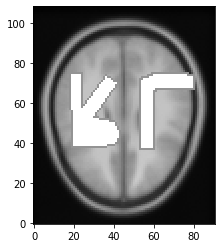

qform_code: 1
qform matrix: 
 [[ -2.   0.   0. 180.]
 [  0.  -2.   0. 216.]
 [  0.   0.   2.   0.]
 [  0.   0.   0.   1.]] 

sform_code: 2
sform matrix: 
 [[ -2.  -0.  -0. 180.]
 [ -0.  -2.  -0. 216.]
 [ -0.  -0.   2.   0.]
 [  0.   0.   0.   1.]] 



In [5]:
filename = os.path.join(cwd, 'data','pmod','avg152T1_PMOD.nii') # Data Saved by PMOD (HFS : radiological)

img      = nib.load(filename)
img_data = img.get_fdata()
img_data = np.reshape(img_data, img_data.shape[0:3]) # PMOD Stores data always as 4D

# Display data matrix
display('Raw data matrix:')
plt.imshow(img_data[:,:,50].T, cmap="gray", origin="lower")
plt.show()

# Orientation information
print('qform_code:', img.header['qform_code']) # 1: Scanner-based
print('qform matrix: \n', img.get_qform(), '\n')

print('sform_code:', img.header['sform_code']) # 2: Aligned
print('sform matrix: \n', img.get_sform(), '\n')

## PMOD: Reset Image (i.e. remove affine and flip data according to RAS orientation)

'Raw data matrix (PMOD Fixed):'

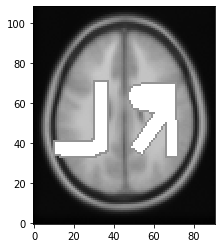

qform_code: 1
qform matrix: 
 [[   2.    0.    0.  -90.]
 [   0.    2.    0. -108.]
 [   0.    0.    2.  -90.]
 [   0.    0.    0.    1.]] 

sform_code: 2
sform matrix: 
 [[   2.    0.    0.  -90.]
 [   0.    2.    0. -108.]
 [   0.    0.    2.  -90.]
 [   0.    0.    0.    1.]] 



In [12]:
img_data_fix = np.rot90(img_data, 2) # LPS to RAS =  180 degree rotation

vox    = img.header.get_zooms()
center = ((np.array(img.shape[0:3]) - 1)  / 2) * vox[0:3] ## CHECK if -1 is needed

affine = np.diag(vox)
affine[0:3,3] = -center

# Save NIfTI file with the RAS orientation and no affine transformation
nii = nib.Nifti1Image(img_data_fix, affine)
nii.header['qform_code'] = 1
nii_filename = os.path.splitext(filename)[0] + '_fixed.nii.gz'
nib.save(nii, nii_filename)

# Display data matrix
display('Raw data matrix (PMOD Fixed):')
plt.imshow(img_data_fix[:,:,50].T, cmap="gray", origin="lower")
plt.show()

# Orientation information
print('qform_code:', nii.header['qform_code']) # 0: Unknown
print('qform matrix: \n', nii.get_qform(), '\n')

print('sform_code:', nii.header['sform_code']) # 2: Aligned
print('sform matrix: \n', nii.get_sform(), '\n')

## Row- and column-order in Python

'NiBabel (Display = M(row,column)):'

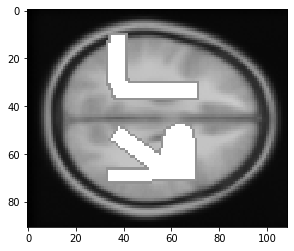

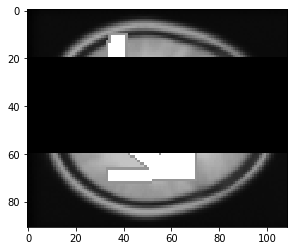

'SimpleITK (Display = M(row,column)):'

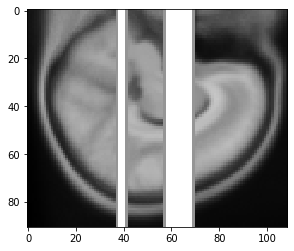

'Remember that SimpleITK uses LPS convention, while NiBabel RAS'

'To have the data in the same orientation, you need to transpose the data'

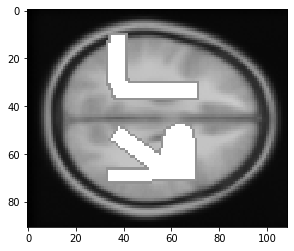

In [7]:
# Load Neurological Convention (RAS) data
filename = os.path.join(cwd, 'data/nifti1/avg152T1_RL_nifti.nii.gz') 

# Load file with NiBabel
nb_img  = nib.load(filename)
nb_data = nb_img.get_fdata()

N0 = copy.deepcopy(nb_data[:,:,50]) # Example slide

# Display data matrix (NiBabel)
plt.figure()
display('NiBabel (Display = M(row,column)):')
plt.imshow(N0, cmap="gray")
plt.show()

# Example, remove part of the data
N1 = copy.deepcopy(N0)
N1[20:60,:] = 0
plt.figure()
plt.imshow(N1, cmap="gray")
plt.show()

# Load file with SimpleITK
import SimpleITK as sitk

reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
reader.SetFileName(filename)
itk_img  = reader.Execute()
itk_data = sitk.GetArrayFromImage(itk_img)

I0 = copy.deepcopy(itk_data[:,:,50])

# Display data matrix (SimpleITK)
plt.figure()
display('SimpleITK (Display = M(row,column)):')
plt.imshow(I0, cmap="gray")
plt.show()

# LPS to RAS
I2 = copy.deepcopy(itk_data.T)[:,:,50]

 # Display data matrix (SimpleITK)
display('Remember that SimpleITK uses LPS convention, while NiBabel RAS')
display('To have the data in the same orientation, you need to transpose the data')
plt.figure()
plt.imshow(I2, cmap="gray")
plt.show()